# Computing window matrices with autodiff - variance reduction

In the other notebook ``isotropic.ipynb``, we estimated the window matrix with ``jax.javrev`` (or ``jax.jacfwd``) over multiple realizations of the field.

However, the memory footprint goes like the power estimation times the dimension of the input power spectrum. This is way to high in practical cases.
To mitigate that, we can take derivatives w.r.t. all input band powers one at a time (typically $\sim 1\;s$ on the GPU), but the computational cost blows up if we also have to average over $\mathcal{O}(100)$ realizations.

However, we can try to beat down the variance.

In [1]:
from pathlib import Path
from functools import partial

import numpy as np
import jax
from jax import numpy as jnp
from jax import random

import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (5, 4)

from jaxpower import (generate_gaussian_mesh, ParticleField, FKPField,
compute_mesh_power, compute_fkp_power, compute_normalization, PowerSpectrumMultipoles)

Let's implement a non-trivial survey selection function, e.g. $\bar{n}(x, y, z) \propto e^{-(x^2 + y^2 + z^2) / (0.2 L)}$, with $L = 2000 \, \mathrm{Mpc}/h$ the box size, truncated at $2\sigma$.

In [2]:
def gaussian_survey(boxsize=2000., meshsize=128, boxcenter=0., size=int(1e7), seed=random.key(42), scale=0.1):
    # Generate Gaussian-distributed positions
    positions = scale * random.normal(seed, shape=(size, 3))
    bscale = 2. * scale  # cut at 2 sigmas
    mask = jnp.all((positions > -bscale) & (positions < bscale), axis=-1)
    positions = positions * boxsize + boxcenter
    toret = ParticleField(positions, weights=1. * mask, boxcenter=boxcenter, boxsize=boxsize, meshsize=meshsize)
    toret = toret.paint(resampler='cic', interlacing=1, compensate=False)
    return toret

def mock_survey(power, selection, repeats=1, unitary_amplitude=False, seed=random.key(42), edges=None, **kwargs):
    # Generate Gaussian field
    mesh = generate_gaussian_mesh(lambda kvec: power(sum(kk**2 for kk in kvec)**0.5),
                                  boxsize=selection.boxsize, meshsize=selection.meshsize, boxcenter=selection.boxcenter,
                                  unitary_amplitude=unitary_amplitude, seed=seed, **kwargs)
    mesh = mesh * selection
    if repeats != 1:
        mesh = mesh.clone(value=jnp.pad(mesh.value, tuple((0, s) for s in mesh.shape), constant_values=0.),
                          boxsize=repeats * mesh.boxsize,
                          meshsize=repeats * mesh.meshsize)
    # Multiply Gaussian field with survey selection function, then compute power spectrum
    norm = compute_normalization(selection, selection)
    return compute_mesh_power(mesh, edges=edges).clone(norm=norm)


We show that we can generate the mock in an enclosing box that can be twice smaller than that used to estimate the power spectrum.

In [3]:
from cosmoprimo.fiducial import DESI
cosmo = DESI(engine='eisenstein_hu_nowiggle')
pk = cosmo.get_fourier().pk_interpolator().to_1d(z=1.)
edges = np.arange(0., 0.2, 0.005)
edgesin = np.arange(0., 0.22, 0.001)
selection = gaussian_survey(boxsize=2000., meshsize=128, scale=0.1)
selection_repeats = gaussian_survey(boxsize=1000., meshsize=64, scale=0.2)

kin = (edgesin[:-1] + edgesin[1:]) / 2.  # FIXME
pkin = pk(kin) * 4 * (1. + 0.2 * np.sin(kin / 0.006))

def get_pkin(pkin):

    def func(k):
        ibin = jnp.digitize(k, edgesin, right=False) - 1
        return jnp.where((ibin >= 0) & (ibin < len(pkin)), pkin[ibin], 0.)

    return func

get_pk = lambda pkin, **kwargs: mock_survey(get_pkin(pkin), selection, edges=edges, **kwargs)
get_wmat = lambda pkin, **kwargs: jax.jacrev(lambda pkin: get_pk(pkin, **kwargs).power[0].real)(pkin)
get_pk_repeats = lambda pkin, **kwargs: mock_survey(get_pkin(pkin), selection_repeats, repeats=2, edges=edges, **kwargs)
get_wmat_repeats = lambda pkin, **kwargs: jax.jacrev(lambda pkin: get_pk_repeats(pkin, **kwargs).power[0].real)(pkin)
get_pk = jax.jit(get_pk, static_argnames=['unitary_amplitude'])
get_wmat = jax.jit(get_wmat, static_argnames=['unitary_amplitude'])
get_pk_repeats = jax.jit(get_pk_repeats, static_argnames=['unitary_amplitude'])
get_wmat_repeats = jax.jit(get_wmat_repeats, static_argnames=['unitary_amplitude'])

/global/common/software/desi/users/adematti/perlmutter/cosmodesiconda/20241221-1.0.0/code/cosmoprimo/main/lib/python3.10/site-packages/cosmoprimo/eisenstein_hu.py:25: UserWarning: EisensteinHuNoWiggleEngine cannot cope with massive neutrinos
  warnings.warn('{} cannot cope with massive neutrinos'.format(self.__class__.__name__))


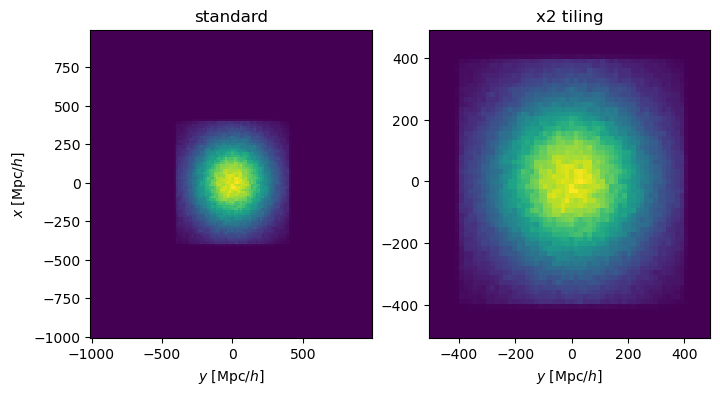

In [4]:
fig, lax = plt.subplots(1, 2, figsize=(8, 4))
lax[0].pcolormesh(*selection.coords()[:2], selection.value[..., selection.shape[-1] // 2])
#lax[0].set_xlim((-500., 500.))
#lax[0].set_ylim((-500., 500.))
lax[0].set_title('standard')
lax[1].pcolormesh(*selection_repeats.coords()[:2], selection_repeats.value[..., selection_repeats.shape[-1] // 2])
lax[1].set_title('x2 tiling')
lax[0].set_ylabel(r'$x$ [$\mathrm{Mpc}/h$]')
for ax in lax:
    ax.set_xlabel(r'$y$ [$\mathrm{Mpc}/h$]')
plt.show()

In [5]:
from tqdm import trange
pks, pkts = [], []
pks_repeats, pkts_repeats = [], []
wmats, wmats_repeats = [], []
npk, npkt = 50, 50
with trange(npk) as t:
    for imock in t:
        seed = random.key(2 * imock)
        pks.append(get_pk(pkin, seed=seed))
        pks_repeats.append(get_pk_repeats(pkin, seed=seed))

with trange(npkt) as t:
    for imock in t:
        # Here we do not use the same seeds
        seed = random.key(2 * imock + 1)
        wmats.append(get_wmat(pkin, seed=seed))
        wmat_repeats = get_wmat_repeats(pkin, seed=seed)
        wmats_repeats.append(wmat_repeats)
        pkts_repeats.append(wmat_repeats.dot(pkin))

100%|██████████| 50/50 [00:04<00:00, 12.15it/s]


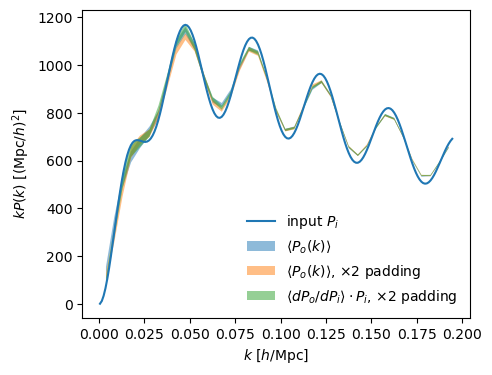

In [6]:
k, edges = pks[0].k, pks[0].edges
pk_mean, pk_std = np.mean([pk.power[0].real for pk in pks], axis=0), np.std([pk.power[0].real for pk in pks], axis=0) / npk**0.5
pk_repeats_mean, pk_repeats_std = np.mean([pk.power[0].real for pk in pks_repeats], axis=0), np.std([pk.power[0].real for pk in pks_repeats], axis=0) / npk**0.5
pkt_repeats_mean, pkt_repeats_std = np.mean(pkts_repeats, axis=0), np.std(pkts_repeats, axis=0) / npkt**0.5

ax = plt.gca()
maskin = kin < edges[-1]
ax.plot(kin[maskin], kin[maskin] * pkin[maskin], label='input $P_i$')
kw = dict(lw=0., alpha=0.5)
ax.fill_between(k, k * (pk_mean - pk_std), k * (pk_mean + pk_std), label=r'$\langle P_o(k) \rangle$', **kw)
ax.fill_between(k, k * (pk_repeats_mean - pk_repeats_std), k * (pk_repeats_mean + pk_repeats_std), label=r'$\langle P_o(k) \rangle$, $\times 2$ padding', **kw)
ax.fill_between(k, k * (pkt_repeats_mean - pkt_repeats_std), k * (pkt_repeats_mean + pkt_repeats_std), label=r'$\langle dP_o/dP_i \rangle \cdot P_i$, $\times 2$ padding', **kw)
ax.set_xlabel(r'$k$ [$h/\mathrm{Mpc}$]')
ax.set_ylabel(r'$k P(k)$ [$(\mathrm{Mpc}/h)^{2}$]')
ax.legend(frameon=False)
plt.show()

Let's test unitary amplitude.

In [7]:
pks_unitary, pks_unitary_repeats, pkts_unitary_repeats = [], [], []

with trange(npk) as t:
    for imock in t:
        seed = random.key(2 * imock)
        pks_unitary.append(get_pk(pkin, seed=seed, unitary_amplitude=True))
        pks_unitary_repeats.append(get_pk_repeats(pkin, seed=seed, unitary_amplitude=True))

with trange(npkt) as t:
    for imock in t:
        # Here we do not use the same seeds
        seed = random.key(2 * imock + 1)
        wmat_repeats = get_wmat_repeats(pkin, seed=seed, unitary_amplitude=True)
        pkts_unitary_repeats.append(wmat_repeats.dot(pkin))

100%|██████████| 50/50 [00:01<00:00, 30.20it/s]


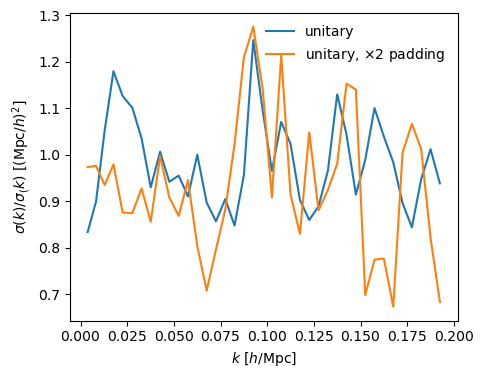

In [8]:
k, edges = pks[0].k, pks[0].edges
pk_mean, pk_std = np.mean([pk.power[0].real for pk in pks], axis=0), np.std([pk.power[0].real for pk in pks], axis=0)
pk_unitary_mean, pk_unitary_std = np.mean([pk.power[0].real for pk in pks_unitary], axis=0), np.std([pk.power[0].real for pk in pks_unitary], axis=0)
pk_unitary_repeats_mean, pk_unitary_repeats_std = np.mean([pk.power[0].real for pk in pks_unitary_repeats], axis=0), np.std([pk.power[0].real for pk in pks_unitary_repeats], axis=0)
pkt_unitary_repeats_mean, pkt_unitary_repeats_std = np.mean(pkts_unitary_repeats, axis=0), np.std(pkts_unitary_repeats, axis=0)

ax = plt.gca()
ax.plot(k, pk_unitary_std / pk_std, label='unitary')
ax.plot(k, pk_unitary_repeats_std / pk_std, label=r'unitary, $\times 2$ padding')
#ax.plot(k, pkt_unitary_repeats_std / pk_std, label=r'matrix: unitary, $\times 2$ padding')
ax.set_xlabel(r'$k$ [$h/\mathrm{Mpc}$]')
ax.set_ylabel(r'$\sigma(k) / \sigma_(k)$ [$(\mathrm{Mpc}/h)^{2}$]')
ax.legend(frameon=False)
plt.show()

In [11]:
print('With the large box mock, gain with unitary amplitude is {:.2f}'.format(np.mean(pk_unitary_std / pk_std)))
print('With the twice smaller box mock, gain with unitary amplitude is {:.2f}'.format(np.mean(pk_unitary_repeats_std / pk_std)))

SyntaxError: '(' was never closed (2099361742.py, line 2)